In [117]:
import pandas as pd
import sys
from top2vec import Top2Vec
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import punkt
from nltk.stem import WordNetLemmatizer
from collections import Counter
# import umap.umap_ as umap
# import umap.plot
nltk.download("stopwords")
import numpy as np
import json
import glob
import gensim
import gensim.corpora as corpora 
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from lib.clean import split_rows_with_multiple_labels

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
def read_data():
    df = pd.read_csv("../data/classification/data/complaint_classification_labeled_data_1_31_2023.csv")
    return df

In [119]:
df = read_data()

In [120]:
def clean_labels(df):
    df.loc[:, "label"] = (df.label.str.lower()
                                  .str.strip()
                                  .str.replace(r"#", "/", regex=False)
                                  .str.replace(r"internal misconduct\/administrative infraction",
                                               "internal misconduct; administrative infraction", regex=True)
    )
    return df

In [121]:
df = df.pipe(clean_labels).pipe(split_rows_with_multiple_labels)

In [122]:
def extract_targets(df):
    dfa = df
    dfa.loc[:, "target"] = (df.label.str.lower()
                                    .str.strip()
                                    .str.replace(r"internal misconduct; administrative infraction", "", regex=False)
    )
    dfa = dfa[~((dfa.target.fillna("") == ""))]
    dfa.loc[:, "target"] = dfa.target.str.replace(r"(.+)", "0", regex=True)

    extract_targets = df.label.str.lower().str.strip().str.extract(r"(internal misconduct; administrative infraction)")

    df.loc[:, "target"] = extract_targets[0].str.replace(r"(.+)", "1", regex=True)
    df = df[~((df.target.fillna("") == ""))]

    df = pd.concat([df, dfa], axis=0)
    df = df.rename(columns={"text": "allegation_desc"})
    return df

In [123]:
df = df.pipe(extract_targets)

In [124]:
def split_data(df):
    training_data, test_data = train_test_split(df, test_size=0.3)
    return training_data, test_data, df

In [125]:
training_data, test_data, og_df = split_data(df)

training_data.to_csv("../data/classification/training_data/training_data.csv", index=False)
test_data.to_csv("../data/classification/test_data/test_data.csv", index=False)

In [126]:
training_data.target.value_counts()

0    915
1    165
Name: target, dtype: int64

In [127]:
test_data.target.value_counts()

0    405
1     58
Name: target, dtype: int64

In [128]:
################################################### top2vec ##################################################################################

In [129]:
def create_model(df):
    # unique = [x for x in df["allegation_topic_uid"]]
    df = [x for x in df["allegation_desc"]]

    model = Top2Vec(
        df,
        ngram_vocab=True,
        speed="deep-learn",
        use_embedding_model_tokenizer=True,
        min_count=5,
        # document_ids=unique
    )
    return model

In [130]:
def model():
    top2vec = create_model(og_df)
    return top2vec

In [131]:
model = model()

2023-02-09 14:33:03,784 - top2vec - INFO - Pre-processing documents for training
2023-02-09 14:33:03,893 - top2vec - INFO - Creating joint document/word embedding
2023-02-09 14:33:42,417 - top2vec - INFO - Creating lower dimension embedding of documents
2023-02-09 14:33:48,802 - top2vec - INFO - Finding dense areas of documents
2023-02-09 14:33:48,854 - top2vec - INFO - Finding topics


In [132]:
if len(model.get_topic_sizes()) > 1:
    topic_words, word_scores, topic_nums = model.get_topics()
    for words, scores, num in zip(topic_words, word_scores, topic_nums):
        print(num)
        print(f"Words: {words}")

0
Words: ['went' 'say' 'ended' 'unknown' 'though' 'never' 'father' 'station'
 'treated' 'should' 'district' 'new orleans' 'auto' 'if' 'letter' 'issue'
 'witness' 'operator' 'told' 'even' 'pedestrian' 'perpetrator' 'didn'
 'feels' 'listen' 'she' 'help' 'what' 'amount' 'been' 'telephone' 'name'
 'who' 'hit' 'happened' 'make' 'spoke' 'three' 'car' 'was' 'neighbor'
 'get' 'nothing' 'decision' 'stated' 'driver' 'orleans' 'acted'
 'subsequently' 'pay']
1
Words: ['investigation revealed' 'searched his' 'automobile' 'activating'
 'violations' 'assisting' 'lights' 'commit' 'glove' 'ticket' 'receive'
 'zone' 'searched' 'citation' 'motorist' 'store' 'lot' 'resigned'
 'compartment' 'traffic' 'driving' 'siren' 'parking' 'where' 'conducting'
 'business' 'car' 'fault' 'rear' 'threats' 'nor' 'including' 'parked'
 'stop' 'guns' 'buttocks' 'blocking' 'following' 'retaliation' 'illegally'
 'dispatcher' 'revealed' 'policy' 'car camera' 'not' 'windows' 'wrong'
 'necessary' 'crash' 'marked']
2
Words: ['orde

In [133]:
topic_sizes, top_nums = model.get_topic_sizes()
print(topic_sizes)
print(top_nums)

[117  93  80  74  74  71  71  71  68  66  65  65  64  63  59  59  55  49
  48  42  41  41  40  35  32]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [134]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=10)

for doc, score, doc_id in list(zip(documents, document_scores, document_ids)):
    print(f"Document: {doc_id}, Score: {score}")
    print("--------------------")
    print(doc)
    print("--------------------")

Document: 387, Score: 0.793195366859436
--------------------
classified inmate wrong.
--------------------
Document: 388, Score: 0.7859219908714294
--------------------
classified inmate wrong.
--------------------
Document: 794, Score: 0.7781868577003479
--------------------
accused of erratic driving, almost causing a wreck.
--------------------
Document: 1464, Score: 0.7633822560310364
--------------------
accused was driving recklessly on i-10 east,
--------------------
Document: 1241, Score: 0.6819431185722351
--------------------
the officer committing several driving violations,
--------------------
Document: 1086, Score: 0.6680116653442383
--------------------
officer located loaded handgun in rear of police unit.
--------------------
Document: 179, Score: 0.634505569934845
--------------------
officer located loaded handgun in rear of police unit.
--------------------
Document: 1232, Score: 0.6318783760070801
--------------------
officer failed to activate his bwc on an automo

In [135]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=20)

ents = {(doc, score) for doc, score in list(zip(documents, document_scores))}
df = pd.DataFrame(ents, columns=["allegation_desc", "score"])
print(df)
df.loc[:, "topic"] = "9"

                                      allegation_desc     score
0   complainant stated that an officer did nothing...  0.464661
1   complainant stated via telephone that three un...  0.448909
2   the complainant feels a driver who hit a pedes...  0.466647
3   complainant stated officers stopped him and ha...  0.526236
4   complainant's father went to the district stat...  0.474444
5   complainant complained via letter that he spok...  0.443288
6   the complainant feels a driver who hit a pedes...  0.478510
7   complainant stated the accused did nothing aft...  0.481509
8   complainant stated she was unable to report a ...  0.485909
9   complainant stated accused officer called him ...  0.534790
10  the complainant feels a driver who hit a pedes...  0.464692
11  accused stated he would make a false accusatio...  0.477766
12  complainant stated he reported his vehicle sto...  0.457061
13  complainant stated that she was rear-ended by ...  0.443056
14  accused stated he would make a false

In [136]:
model.save("models/top2vec_train_model")

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_

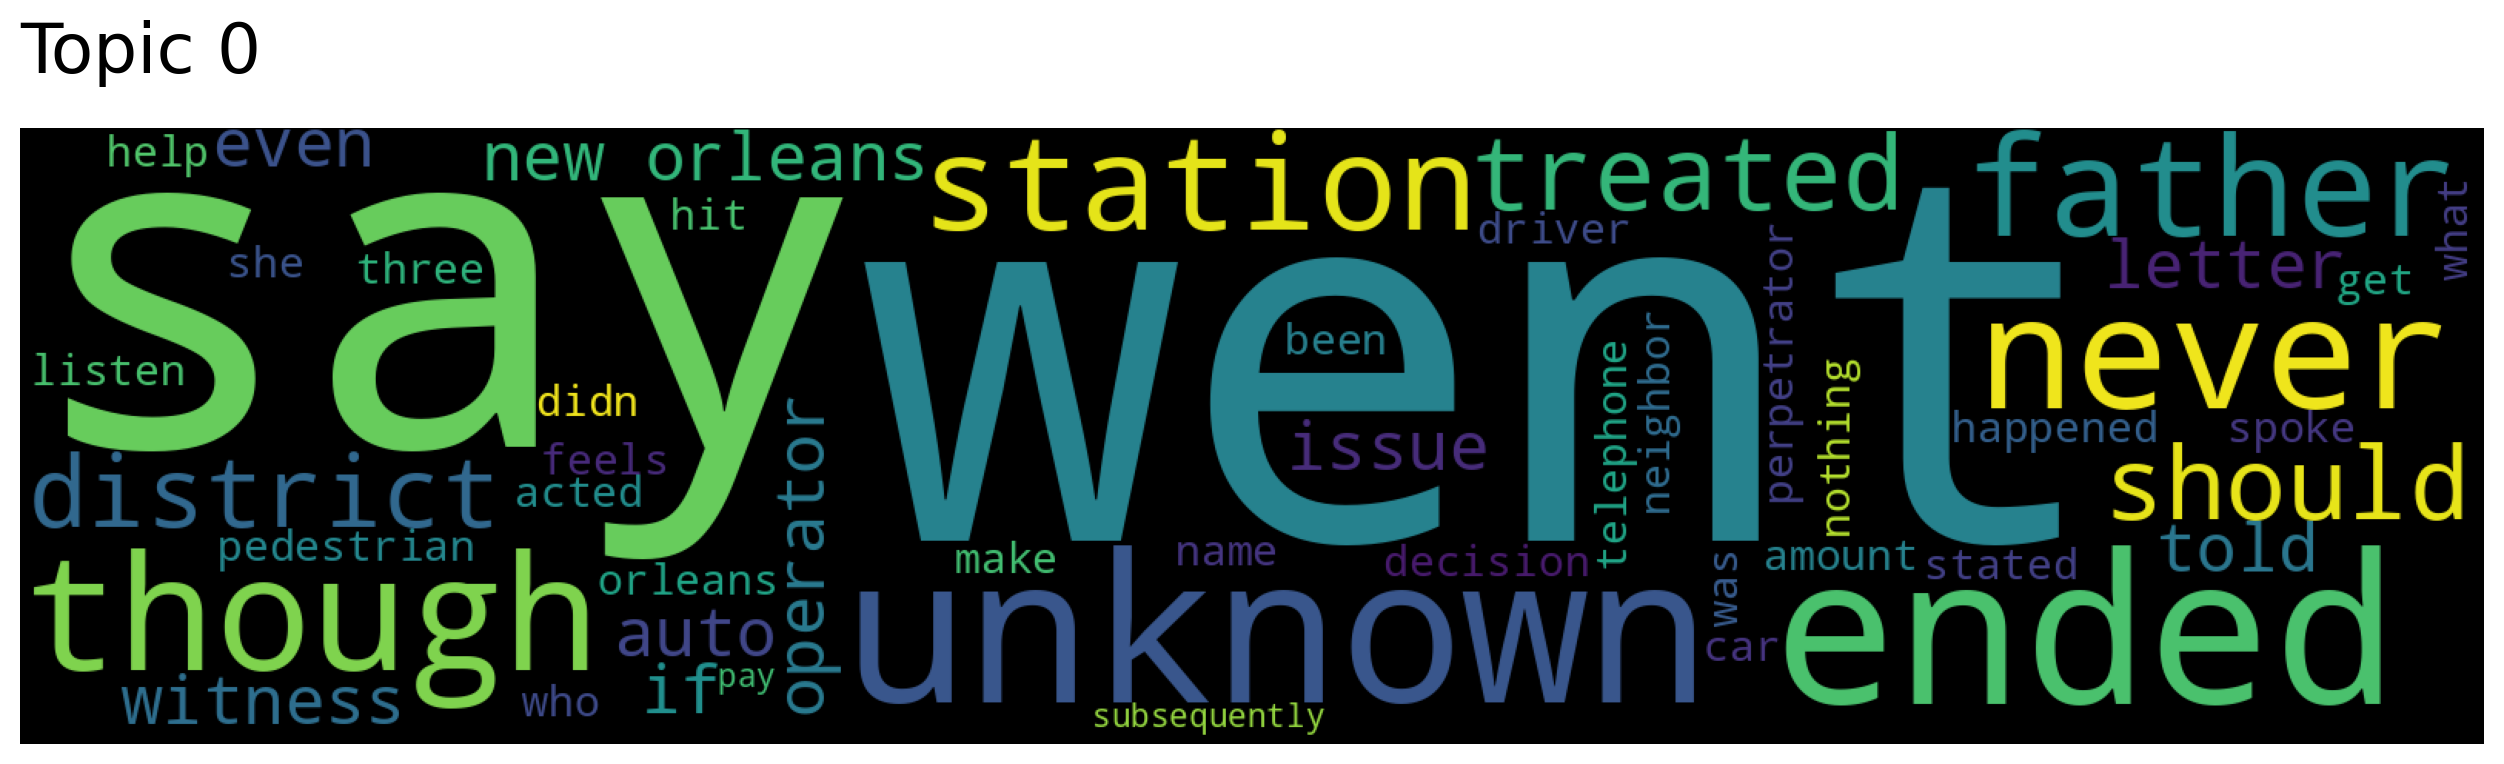

In [137]:
model.generate_topic_wordcloud(0)

In [138]:
model.topic_words

array([['went', 'say', 'ended', ..., 'acted', 'subsequently', 'pay'],
       ['investigation revealed', 'searched his', 'automobile', ...,
        'necessary', 'crash', 'marked'],
       ['order', 'thus', 'unjustly', ..., 'taking', 'based', 'following'],
       ...,
       ['as scheduled', 'in verbal', 'appear', ..., 'neglect',
        'fatality', 'allegation neglect'],
       ['supervisory duties', 'duties', 'perform', ..., 'secure',
        'an accident', 'necessary'],
       ['extended', 'lunch break', 'lunch', ..., 'patrol', 'worked',
        'engaged']], dtype='<U26')

In [139]:
model.topic_words[0]

array(['went', 'say', 'ended', 'unknown', 'though', 'never', 'father',
       'station', 'treated', 'should', 'district', 'new orleans', 'auto',
       'if', 'letter', 'issue', 'witness', 'operator', 'told', 'even',
       'pedestrian', 'perpetrator', 'didn', 'feels', 'listen', 'she',
       'help', 'what', 'amount', 'been', 'telephone', 'name', 'who',
       'hit', 'happened', 'make', 'spoke', 'three', 'car', 'was',
       'neighbor', 'get', 'nothing', 'decision', 'stated', 'driver',
       'orleans', 'acted', 'subsequently', 'pay'], dtype='<U26')

In [140]:
topic_words, word_scores, topic_nums = model.get_topics(0)
for words, scores, nums in zip(topic_words, word_scores, topic_nums):
  print("Topic Number: ",nums)
  print(f"Words: {words}")
  print("\n")

In [141]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["inmate"], num_topics=0)
for word, w_score, topic, t_score in list(zip(topic_words, word_scores, topic_scores, topic_nums)):
    print(f"Word: \n{word}")
    print("--------------------")
    print(f"Word Score \n{w_score}")
    print("--------------------")
    print(f"Topic Score: \n{topic}")
    print("--------------------")
    print (f"Topic # \n{t_score}")
    print("--------END---------")

Word: 
['spray' 'oc' 'trap' 'mitchell' 'deploying' 'oc spray' 'intimidate'
 'inmate mitchell' 'deployed' 'cell phone' 'cell' 'inmate' 'through'
 'door' 'food' 'dorm' 'area' 'contact' 'assgned' 'cew' 'an inmate'
 'retrieve' 'permission' 'falsifying' 'inmates'
 'allegation professionalism' 'search warrant' 'restrained' 'able' 'using'
 'activate his' 'arrest warrant' 'husband' 'marijuana' 'possession'
 'phone' 'attitude' 'observed' 'had been' 'domestic incident' 'seat'
 'confiscated' 'issued summons' 'offender' 'giving' 'angry' 'when they'
 'relative' 'made' 'opened']
--------------------
Word Score 
[0.904446   0.89225286 0.8922438  0.8897377  0.8444218  0.79660183
 0.6716975  0.63120013 0.6254727  0.5287192  0.51417476 0.4934889
 0.4925086  0.4440802  0.4411107  0.4386103  0.42435348 0.39173785
 0.37783396 0.37380013 0.36018938 0.347996   0.33929804 0.33705145
 0.33690777 0.32202592 0.31803465 0.30498776 0.30368155 0.30233237
 0.300088   0.29227427 0.28741825 0.2854571  0.28368837 0.267

In [142]:
# model = Top2Vec.load("models/noso")

# umap_args = {
#     "n_neighbors": 15,
#     "n_components": 2, # 5 -> 2 for plotting 
#     "metric": "cosine",
# }
# umap_model = umap.UMAP(**umap_args).fit(model.topic_vectors)
# umap.plot.points(umap_model, labels=model.doc_top_reduced)

In [143]:
############################################################ bertopic #################################################################

In [144]:
docs = og_df.allegation_desc

In [145]:
docs = json.loads(docs.to_json(orient='records'))

In [146]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)
embeddings = np.array(embeddings)
embeddings = pd.DataFrame(embeddings).to_csv("vecs/bert_train_vecs.csv", index=False)

Batches: 100%|██████████| 49/49 [00:18<00:00,  2.60it/s]


In [147]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", vectorizer_model=vectorizer_model, diversity=0.2)

In [148]:
topic, probs = topic_model.fit_transform(docs)

In [149]:
topic_model.save("models/bert_train_model")

In [150]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,123,-1_arrested_daughter_spray_warrant
1,0,748,0_complainant_officer_police_officers
2,1,63,1_camera_activate_pursuit_vehicle
3,2,58,2_inmates_dorm_cell_deputy
4,3,42,3_2021_accused_reporting_imate
5,4,42,4_bwc_activate_cew_packet
6,5,38,5_duty_minutes_scheduled_rported
7,6,33,6_unauthorized_illegal_grabbed_officers
8,7,28,7_falsely_arrested_falsifying_parish
9,8,28,8_lunch_assignment_instructed_failed


In [151]:
topic_model.get_topic(3)

[('2021', 0.18711405321187305),
 ('accused', 0.10219211439138906),
 ('reporting', 0.09606995371825627),
 ('imate', 0.0923431369499258),
 ('inspections', 0.07720792129983166),
 ('provocation', 0.061133853375251346),
 ('breaching', 0.061133853375251346),
 ('unauthorized', 0.05995267906337534),
 ('protection', 0.0516442049863325),
 ('duty', 0.04780718921185336)]

In [152]:
topic_model.get_representative_docs(3)

['accused of not completing the shakedown that was assigned on 6/2/2021.',
 'accused of not reporting to his work assignment as instructed.',
 'accused of not completing her two cell inspections per shift.']

In [153]:
topic_model.visualize_topics()

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [154]:
topic_model.visualize_barchart()

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [155]:
df_bert = pd.DataFrame({"topic": topic, "documents": docs})

In [156]:
df_bert

,topic,documents
0,0,the former chief of police received a complain...
1,-1,alleges officer burr made inappropriate facebo...
2,-1,refused an assignment.
3,20,left work without informing her rank.
4,13,failed to inform his supervisor that he would ...
...,...,...
1538,1,officer failed to activate his body-worn camer...
1539,0,officers accused of not making an arrest in a ...
1540,0,complainant stated that the officer discrimina...
1541,0,the complainant stated the officer was instruc...


In [157]:
############################################################ gensim ##############################################################################

In [158]:
train_docs = og_df.allegation_desc

In [159]:
def lemmatization(descs, allowed_pos_tags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    final_text = []
    for desc in descs:
        doc = nlp(desc)
        new_text = " ".join([token.lemma_ for token in doc if token.pos_ in allowed_pos_tags])
        final_text.append(new_text)
    return (final_text)

In [160]:
lemmatized_texts = lemmatization(docs)

In [161]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [162]:
data_words = gen_words(lemmatized_texts)

In [163]:
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return list(bigram[doc] for doc in texts)

def make_trigrams(texts):
    return list(trigram[bigram[doc]] for doc in texts)

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_words)

In [164]:
id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

train_corpus = [id2word.doc2bow(text) for text in texts]
# print(train_corpus[0][0:20])

tdidf = TfidfModel(train_corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tdif = []

for i in range(0, len(train_corpus)):
    bow = train_corpus[i]
    low_value_words = []
    tdif_ids = [id for id, value in tdidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tdidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tdif
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tdif = [id for id in bow_ids if id not in tdif_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tdif]
    train_corpus[i] = new_bow

In [165]:
gensim_model = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                        #    per_word_topics=True,
                                           alpha="auto")
gensim_model.save('models/gensim_train.model')

In [166]:
gensim_model.print_topics(5, num_words=20)[:10]

[(15,
  '0.230*"find" + 0.058*"cell_phone" + 0.023*"possession" + 0.000*"warrant" + 0.000*"vehicle" + 0.000*"son" + 0.000*"search" + 0.000*"property" + 0.000*"say" + 0.000*"residence" + 0.000*"husband" + 0.000*"seat" + 0.000*"neglect" + 0.000*"sister" + 0.000*"girlfriend" + 0.000*"revolver" + 0.000*"thus" + 0.000*"ask" + 0.000*"damage" + 0.000*"also"'),
 (19,
  '0.314*"leave" + 0.059*"authorization" + 0.035*"control" + 0.019*"pod" + 0.007*"repot" + 0.000*"stop" + 0.000*"also" + 0.000*"dispatch" + 0.000*"motorist" + 0.000*"activity" + 0.000*"district" + 0.000*"vehicle" + 0.000*"room" + 0.000*"unattended" + 0.000*"university" + 0.000*"center" + 0.000*"medical" + 0.000*"scene" + 0.000*"crime" + 0.000*"lab"'),
 (2,
  '0.774*"fail" + 0.036*"notify" + 0.019*"rank" + 0.000*"report" + 0.000*"allegation" + 0.000*"vehicle" + 0.000*"action" + 0.000*"neglect" + 0.000*"traffic" + 0.000*"stop" + 0.000*"domestic_violence" + 0.000*"professionalism" + 0.000*"warrant" + 0.000*"use_force" + 0.000*"servic

In [167]:
def gensim_vecs():
    gensim_train_vecs = []
    for i in range(len(train_docs)):
        top_topics = gensim_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(20)]
        topic_vec.extend([len(train_docs.iloc[i])]) 
        gensim_train_vecs.append(topic_vec)
    return gensim_train_vecs

In [168]:
gensim_vecs = gensim_vecs()
gensim_vecs = np.array(gensim_vecs)
gensim_vecs = pd.DataFrame(gensim_vecs).to_csv("vecs/gensim_train_vecs.csv", index=False)

In [169]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(gensim_model, train_corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.483596 -0.285522       1        1  50.904658
7     -0.439882  0.091966       2        1   7.721121
2      0.028766 -0.410485       3        1   5.101179
11    -0.167599 -0.337273       4        1   4.926950
10     0.089072  0.351107       5        1   3.348844
18    -0.125425  0.350897       6        1   3.347918
13    -0.277616  0.208132       7        1   3.338583
8     -0.223776 -0.055483       8        1   2.926985
17     0.203108 -0.293970       9        1   2.918524
12     0.364733 -0.103772      10        1   2.863659
6      0.185493 -0.137099      11        1   1.803161
14     0.297069  0.217510      12        1   1.798012
9     -0.057631 -0.070919      13        1   1.502004
1     -0.037484  0.057508      14        1   1.326146
16    -0.024950  0.166986      15        1   1.279587
4      0.112487  0.188636      16        1   1.165288
5      0.063591 -0.080401      17        1   1.118130
3      0.242080  0.026643      18        1   1.036325
19     0.168268  0.078840      19        1   0.941854
15     0.083291  0.036699      20        1   0.631071, topic_info=            Term         Freq        Total Category  logprob  loglift
32          fail   736.000000   736.000000  Default  30.0000  30.0000
7        officer  2887.000000  2887.000000  Default  29.0000  29.0000
315  complainant  2400.000000  2400.000000  Default  28.0000  28.0000
252       arrest   537.000000   537.000000  Default  27.0000  27.0000
45        accuse  1639.000000  1639.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
287          ask     0.043662     1.438392  Topic20  -7.8973   1.5707
855        drive     0.043658     1.438083  Topic20  -7.8974   1.5708
550        front     0.043660     1.438374  Topic20  -7.8974   1.5707
373      neglect     0.043666     1.439130  Topic20  -7.8972   1.5703
416         also     0.043661     1.438699  Topic20  -7.8974   1.5705

[769 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
179       8  0.472638  abandon
45        1  0.998997   accuse
238      14  0.816510    admit
146      11  0.370040   affair
186      13  0.731424    agent
...     ...       ...      ...
117      13  0.851873     wear
195      14  0.515494   weekly
27       10  0.981838     work
191      13  0.506636   wrrite
145      11  0.927410     year

[275 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 3, 12, 11, 19, 14, 9, 18, 13, 7, 15, 10, 2, 17, 5, 6, 4, 20, 16])